In [ ]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker, parafac, partial_tucker
from tensorly import tucker_to_tensor
import pandas as pd
import scipy.linalg as la
from PIL import Image
import matplotlib.pyplot as plt
from libcrap import traverse_files
from pprint import pprint
import re
from tqdm import tqdm_notebook as tqdm
import os
import doctest
from itertools import product
from random import shuffle
import random
from functools import reduce
import operator
import pickle
import matplotlib.ticker as ticker

Using numpy backend.


In [ ]:
x = np.arange(1, 28, dtype=np.float64).reshape((3, 3, 3), order="F")
# if we omit np.float64 dtype, tensorly will fuck up
# trying to work with a matrix of ints

In [ ]:
x

In [ ]:
x[:, 0, 0]

In [ ]:
tl.unfold(x, 0)

In [ ]:
x.astype(np.float32)

In [ ]:
cp_factors, approximation_errors = parafac(
    x.astype(np.float32), rank=1, n_iter_max=10000, init="random", return_errors=True
)

In [ ]:
for factor in cp_factors:
    print(factor)
    print()

In [ ]:
np.kron(np.kron(cp_factors[0], cp_factors[1]), cp_factors[2]).reshape((3, 3, 3))

In [ ]:
# and what if we add orthogonalize option?
orthogonal_cp_factors, orthogonal_cp_approximation_errors = parafac(
    x.astype(np.float32), rank=1, n_iter_max=10000, init="random",
    return_errors=True, orthogonalise=True
)

In [ ]:
for factor in orthogonal_cp_factors:
    print(factor)
    print()

In [ ]:
# Oh, I guess it shouldn't do anything because rank is 1

In [ ]:
tucker_core, tucker_factors = tucker(
    x, ranks=(1, 1, 1), n_iter_max=10000, init="random"
)

In [ ]:
tucker_core

In [ ]:
for factor in tucker_factors:
    print("{}\nl-2 norm = {}\n".format(factor, la.norm(factor, 2)))

In [ ]:
tucker_core, tucker_factors = tucker(
    x, ranks=(2, 2, 2), n_iter_max=10000, init="random"
)

In [ ]:
for factor in tucker_factors:
    print("{}\nl-2 norm = {}\n".format(factor, la.norm(factor, 2, axis=0)))

In [ ]:
ETH_80_PATH = "/home/shibbiry/Documents/datasets/eth80/eth80-cropped-close128"

In [ ]:
all_filenames = list(traverse_files(ETH_80_PATH))

In [ ]:
NUM_CLASSES = 8
NUM_OBJECTS_PER_CLASS = 10
NUM_OBJECTS = 8*10
NUM_ANGLES = 41
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNELS = 3

In [ ]:
class DictWithCounter(dict):
    """
    >>> d = DictWithCounter()
    >>> print(d.get_maybe_add("aaa"))
    0
    >>> print(d.get_maybe_add("bbb"))
    1
    >>> print(d.get_maybe_add("aaa"))
    0
    >>> print(sorted(d.items()))
    [('aaa', 0), ('bbb', 1)]
    """
    def __init__(self):
        super(DictWithCounter, self).__init__()
        self._next_value = 0
    
    def get_maybe_add(self, item):
        if item not in self:
            self[item] = self._next_value
            self._next_value += 1
        return self[item]

In [ ]:
doctest.run_docstring_examples(DictWithCounter, globals())

In [ ]:
dataset = np.zeros(
    (NUM_OBJECTS, NUM_ANGLES, IMAGE_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH),
    dtype=np.float32, order="C"
)

In [ ]:
object_classes = [None] * NUM_OBJECTS
object_id_to_index = DictWithCounter()
angles_to_index = DictWithCounter()
for path in tqdm(all_filenames):
    match = re.search(r"([a-z]+)(\d\d?)-(\d\d\d-\d\d\d).png", path)
    if not match:
        continue
        
    object_id = match.group(1) + match.group(2)    
    angles = match.group(3)
    
    object_index = object_id_to_index.get_maybe_add(object_id)
    angles_index = angles_to_index.get_maybe_add(angles)
    object_classes[object_index] = match.group(1)
    
    image = plt.imread(path)
    dataset[object_index, angles_index] = np.moveaxis(image, 2, 0)

In [ ]:
dataset.shape

(80, 41, 3, 128, 128)

In [ ]:
def fix_img_axes_for_show(image):
    return np.moveaxis(image, 0, 2)

In [ ]:
def choose_random_image():
    return random.randint(0, NUM_OBJECTS-1), random.randint(0, NUM_ANGLES-1)

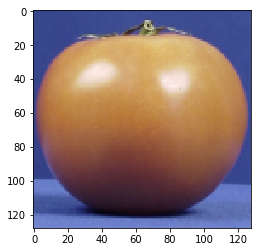

In [ ]:
plt.imshow(fix_img_axes_for_show(dataset[choose_random_image()]))

In [ ]:
ranks_list = list(product(
    range(1, 32, 3),
    [3],
    range(1, 57, 11),
    range(1, 57, 11)
))
print(len(ranks_list))

396


In [ ]:
cores = []
factors_list = []
tl.set_backend("pytorch")
dataset_gpu = tl.tensor(dataset, device="cuda")
for ranks in tqdm(ranks_list):
    core, factors = partial_tucker(
        dataset_gpu, list(range(1, 5)), ranks, n_iter_max=100,
        init="svd"
    )
    cores.append(core.cpu().numpy())
    factors_numpy = [factor.cpu().numpy() for factor in factors]
    factors_list.append(factors_numpy)

Using pytorch backend.


/home/shibbiry/soft/conda/lib/python3.7/site-packages/tensorly/backend/numpy_backend.py:241: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(S)


In [ ]:
decompositions_info = pd.DataFrame(
    [
        (core.shape, np.log(reduce(operator.mul, core.shape)))
        for core in cores
    ],
    columns=("ranks", "ranks_mul")
)

In [ ]:
largest_decomposition_index = decompositions_info["ranks_mul"].idxmax()
print(largest_decomposition_index)
print(decompositions_info.loc[largest_decomposition_index])

395
ranks        [80, 31, 3, 56, 56]
ranks_mul                16.9653
Name: 395, dtype: object


In [ ]:
tl.set_backend("numpy")
dataset_reconstructed = np.zeros_like(dataset)
for object_index in tqdm(range(NUM_OBJECTS)):
    dataset_reconstructed[object_index] = tucker_to_tensor(
        cores[largest_decomposition_index][object_index],
        factors_list[largest_decomposition_index]
    )

Using numpy backend.


In [ ]:
def imshow_pair(object_index, angle_index):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    image_original = np.moveaxis(
        dataset_reconstructed[object_index, angle_index], 0, 2
    )
    axes[0].imshow(fix_img_axes_for_show(dataset[object_index, angle_index]))
    axes[1].imshow(fix_img_axes_for_show(dataset_reconstructed[object_index, angle_index]))

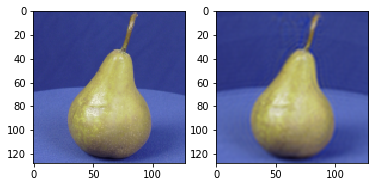

In [ ]:
imshow_pair(*choose_random_image())

In [ ]:
# Idea: subtract mean from each image
# or remove background using maps

In [ ]:
with open("cores.pkl", "wb") as cores_file:
    pickle.dump(cores, cores_file)

In [ ]:
with open("factors_list.pkl", "wb") as factors_list_file:
    pickle.dump(factors_list, factors_list_file)

In [ ]:
decompositions_info.to_json("decompositions_info.json")

In [ ]:
# load data
with open("cores.pkl", "rb") as cores_file:
    cores = pickle.load(cores_file)

In [ ]:
with open("factors_list.pkl", "rb") as factors_list_file:
    factors_list = pickle.load(factors_list_file)

In [ ]:
decompositions_info = pd.read_json("decompositions_info.json").sort_index()

In [ ]:
decompositions_info.ranks_mul.sort_values()

In [ ]:
random_images = [choose_random_image(), choose_random_image(), choose_random_image()]

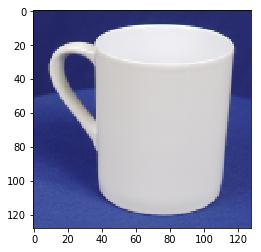

In [ ]:
plt.imshow(fix_img_axes_for_show(dataset[random_images[0]]))

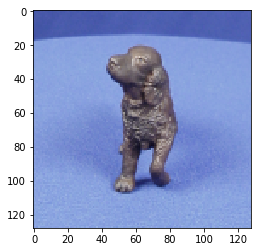

In [ ]:
plt.imshow(fix_img_axes_for_show(dataset[random_images[1]]))

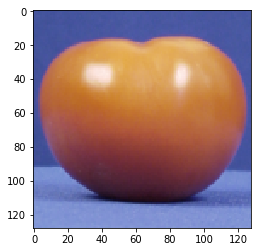

In [ ]:
plt.imshow(fix_img_axes_for_show(dataset[random_images[2]]))

In [ ]:
decompositions_indices = list(range(45, len(decompositions_info), len(decompositions_info) // 2)) + [395]
print(decompositions_indices)

[45, 243, 395]


In [ ]:
decompositions_info

,ranks,ranks_mul
0,"[80, 1, 3, 1, 1]",5.480639
1,"[80, 1, 3, 1, 12]",7.965546
2,"[80, 1, 3, 1, 23]",8.616133
3,"[80, 1, 3, 1, 34]",9.006999
4,"[80, 1, 3, 1, 45]",9.287301
5,"[80, 1, 3, 1, 56]",9.505991
6,"[80, 1, 3, 12, 1]",7.965546
7,"[80, 1, 3, 12, 12]",10.450452
8,"[80, 1, 3, 12, 23]",11.101040
9,"[80, 1, 3, 12, 34]",11.491906


In [ ]:
for ranks in decompositions_info.loc[decompositions_indices].ranks:
    a, b, c, d, e = ranks
    print((a*b*c*d*e + b*41 + c*3 + d*128 + e*128) / reduce(lambda x, y: x * y, dataset.shape))

0.0024670918782552084
0.043343024525215955
0.14481866107723576


In [ ]:
print(reduce(lambda x, y: x * y, dataset.shape))

161218560


Using numpy backend.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


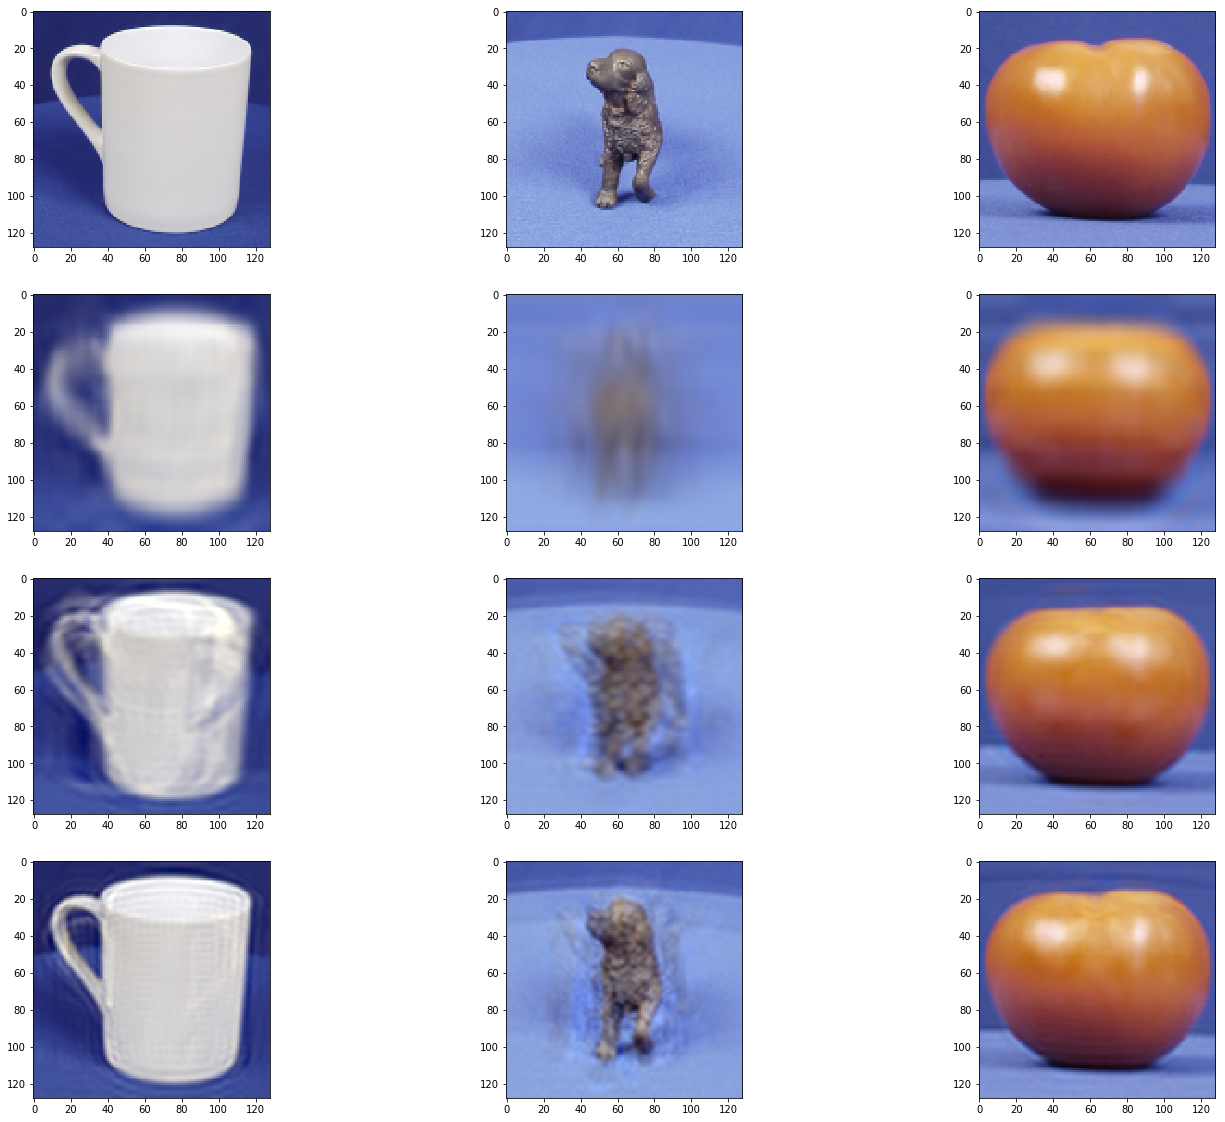

In [ ]:
%matplotlib inline
tl.set_backend("numpy")
fig, axes = plt.subplots(4, 3, figsize=(24, 20))
for i in range(3):
    axes[0, i].imshow(fix_img_axes_for_show(dataset[random_images[i]]))
for dec_ind, axes_row in zip(decompositions_indices, axes[1:]):
    core = cores[dec_ind]
    factors = factors_list[dec_ind]
    dataset_reconstructed = np.zeros_like(dataset)
    for object_index in range(NUM_OBJECTS):
        dataset_reconstructed[object_index] = tucker_to_tensor(
            core[object_index],
            factors
        )
    for i in range(3):
        axes_row[i].imshow(fix_img_axes_for_show(dataset_reconstructed[random_images[i]]))

In [ ]:
diff = dataset_reconstructed - dataset

In [ ]:
np.abs(diff).mean()

0.022392055

In [ ]:
dataset.max()

1.0

In [ ]:
diff.mean()

3.653542e-07

In [ ]:
# let's calc reconstruction errors
nums_parameters = []
diffs = []
for dec_ind in tqdm(range(len(decompositions_info))):
    ranks = decompositions_info.ranks.loc[dec_ind]
    a, b, c, d, e = ranks
    nums_parameters.append((a*b*c*d*e + b*41 + c*3 + d*128 + e*128) / reduce(lambda x, y: x * y, dataset.shape))
    core = cores[dec_ind]
    factors = factors_list[dec_ind]
    dataset_reconstructed = np.zeros_like(dataset)
    for object_index in range(NUM_OBJECTS):
        dataset_reconstructed[object_index] = tucker_to_tensor(
            core[object_index],
            factors
        )
    diffs.append(np.abs(dataset - dataset_reconstructed).mean())

Text(0,0.5,'Mean absolute error')

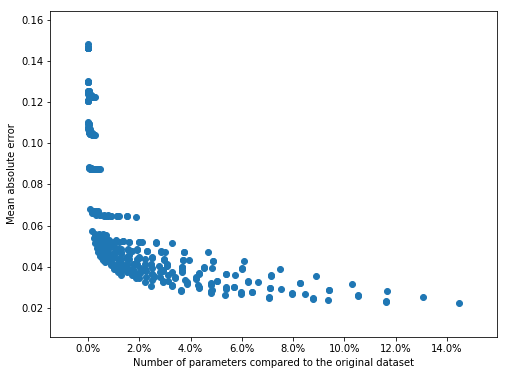

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(nums_parameters, diffs)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_xlabel("Number of parameters compared to the original dataset")
ax.set_ylabel("Mean absolute error")